# Storm prediction by Ciaran group

## Task 1: Predict image of storm evolution
For this task, we are given 30 sets of images of different storms and then try to predict images of the missing storm images in the future. Our final approach is to use the Convolutional-LSTM architecture discussed in depth in this notebook, as other models we tried did not achieve as good results, and will be demonstrated down below. (See under miscellaneous/generates_storm_images for detailed notebook of our attempts with other models)

In [1]:
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

import io
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 14.6 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


If you want to use the `Tools` module in Google Colab, do the following steps:
1. Mount Google Drive into the Colab environment
```
from google.colab import drive
drive.mount('/content/drive')
```
2. Add the directory of the project to `sys.path`
```
sys.path.append(project_dir)
```
3. Upload the `Tools` folder from the repository into the directory of the project on Google Drive.
```
from Tools.Utils import set_seed, set_device, generate_combinations
from Tools.StormDataset import StormDataset
from Tools.Model import EncoderDecoderConvLSTM
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sys.path.append("/content/drive/MyDrive/Storm_Project")

In [4]:
from Tools.Utils import set_seed, set_device, get_images_from_zip, generate_combinations
from Tools.StormDataset import StormDataset
from Tools.Model import EncoderDecoderConvLSTM

In [5]:
device = set_device("cuda")

Cuda installed! Running on GPU 0 Tesla V100-SXM2-16GB!


## Exploratory Data Analysis

In [6]:
# The path of the folder containing *.csv files
csv_folder_path = "/content/drive/MyDrive/Storm_Project/storm_data_csv"

# Get a list of all *.csv files in the folder
files = [csv for csv in os.listdir(csv_folder_path) if csv.endswith('.csv')]

# Initialise an empty DataFrame to store the data contained in all *.csv files
all_data = pd.DataFrame()

# Loop through the list to read each file and concatenate it into the DataFrame
for file in files:
    file_path = os.path.join(csv_folder_path, file)
    data_from_1_csv = pd.read_csv(file_path)
    all_data = pd.concat([all_data, data_from_1_csv], ignore_index=True)

# Convert the data types of numeric columns to integers
all_data[['relative_time', 'ocean', 'wind_speed']] = all_data[['relative_time', 'ocean', 'wind_speed']].astype(int)

all_data

storm_id  relative_time  ocean  wind_speed image_file_name
0         rml              0      2          25     rml_000.jpg
1         rml           1800      2          25     rml_001.jpg
2         rml           3600      2          25     rml_002.jpg
3         rml           7203      2          25     rml_003.jpg
4         rml           9000      2          25     rml_004.jpg
...       ...            ...    ...         ...             ...
9522      ipa         961200      1          37     ipa_444.jpg
9523      ipa         963000      1          37     ipa_445.jpg
9524      ipa         964800      1          36     ipa_446.jpg
9525      ipa         966600      1          36     ipa_447.jpg
9526      ipa         968400      1          35     ipa_448.jpg

[9527 rows x 5 columns]

In [7]:
# Get all storm images
zip_path = '/content/drive/MyDrive/Storm_Project/all_storm_image.zip'
images = get_images_from_zip(zip_path)

9527


## StormDataset

We have written a cutomized dataloader, which in each batch, we will load numbers of sequences of images as well as a prediction label.

In [8]:
# Initialise a StormDataset object for the storm "bkh"
storm = "bkh"
storm_ds = StormDataset(all_data, storm, num_sequence=20, all_images_dict=images, img_size=366)
# See image statistics
mean, std = storm_ds.mean, storm_ds.std
print(f"The images of the {storm} storm have the mean of {storm_ds.mean} and the SD of {storm_ds.std}.")

The images of the bkh storm have the mean of 0.27985233068466187 and the SD of 0.2152128517627716.


In [ ]:
# Initialise a StormDataset object for each storm and store it in a list
all_storm_ids = all_data['storm_id'].unique()  # 30 storms
all_storm_ds = {}
for storm_id in all_storm_ids:
    all_storm_ds[storm_id] = StormDataset(all_data, storm_id, num_sequence=20, all_images_dict=images, img_size=366)

## Method to train the model

In [9]:
def train(train_loader, optimizer, criterion, model, device):
    """
    Train the given model using the provided training data.

    Parameters
    ----------
    train_loader: torch.utils.data.DataLoader

        The DataLoader for the training dataset.

    optimizer: torch.optim.Optimizer

        An optimization algorithm.

    criterion: torch.nn.Module

        A loss function.

    model: torch.nn.Module

        The model to be trained.

    device: torch.device

        The device (CPU or GPU) on which the training will be performed.

    Return
    ------
    float

        The average training loss over the training dataset.

    """
    model.train()
    train_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss/len(train_loader)
    return avg_train_loss.item()

## Method to validate the model

In [10]:
def validate(val_loader, criterion, model, device):
    """
    Validate the given model using the provided validation data.

    Parameters
    ----------
    val_loader: torch.utils.data.DataLoader

        The DataLoader for the validation dataset.

    criterion: torch.nn.Module

        A loss function.

    model: torch.nn.Module

        The model to be validated.

    device: torch.device

        The device (CPU or GPU) on which the validation will be performed.

    Return
    ------
    float

        The average validation loss over the validation dataset.

    """
    model.eval()
    val_loss = 0
    for X, y in val_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2.view(-1, a2.shape[-2]*a2.shape[-1]), y.view(-1, a2.shape[-2]*a2.shape[-1]))
            val_loss += loss*X.size(0)

    avg_val_loss = val_loss/len(val_loader)
    return avg_val_loss.item()

## Train-test split

In [11]:
train_set = storm_ds[:int(len(storm_ds)*0.8)]
val_set = storm_ds[int(len(storm_ds)*0.8):]

## Preparing the DataLoaders

In [12]:
# Create the data loaders of the training and validation datasets
batch_size = 2
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [13]:
# Check the size of a batch in the training data loader
for i in train_loader:
    print(i[0].shape)
    print(i[1].shape)
    break

torch.Size([2, 20, 1, 366, 366])
torch.Size([2, 3, 1, 366, 366])


## Initialising a model

The reason why we choose to use the Encoder-Decoder ConvLSTM architecture for this time-series predictive image generation task is because this approach combines the strengths of Convolutional Neural Networks (CNNs) in handling spatial information with the capabilities of Long Short-Term Memory (LSTM) networks to model temporal dependencies.
 
The encoder-decoder structure, when equipped with convolutional layers, excels at capturing spatial hierarchies and dependencies within images. It can effectively learn spatial features such as edges, textures, and patterns that are crucial for image generation tasks. While LSTMs are designed to capture long-term dependencies in sequential data. By incorporating LSTM units into the architecture (ConvLSTM), the model can understand temporal sequences, making it ideal for predicting future frames based on past observations.


![ConvLSTM Architecture](resources/images/convLSTM.png)

In [14]:
# Initialise an encoder-decoder convolutional LSTM model
set_seed(0)
model = EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=3, num_convlstm_de=4).to(device)
model

EncoderDecoderConvLSTM(
  (convlstm_encoders): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (convlstm_decoders): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(5, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (cnn_decoders): Sequential(
    (0): Conv3d(3, 3, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): Tanh()
    (2): Co

## Setting hyperparameters, criterion, and optimiser

In [ ]:
# Set hyperparameters, criterion, and optimiser
lr = 5e-4
n_epochs = 20
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def plot_learning_curve(n_epochs, train_loader, val_loader, optimizer, criterion, model, device):
    """
    Plot the learning curve of the model.

    Parameters
    ----------
    n_epochs: int

        The number of training epoches.

    train_loader: torch.utils.data.DataLoader

        The DataLoader for the training dataset.

    val_loader: torch.utils.data.DataLoader

        The DataLoader for the validation dataset.

    optimizer: torch.optim.Optimizer

        An optimization algorithm.

    criterion: torch.nn.Module

        A loss function.

    model: torch.nn.Module

        The model to be trained.

    device: torch.device

        The device (CPU or GPU) on which the training will be performed.

    """
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss = train(train_loader, optimizer, criterion, model, device)
        print(epoch, train_loss)
        logs['' + 'log loss'] = train_loss
        logs['val_'+ 'log loss'] = validate(val_loader, criterion, model, device)
        liveloss.update(logs)
        liveloss.draw()

## Training and validation

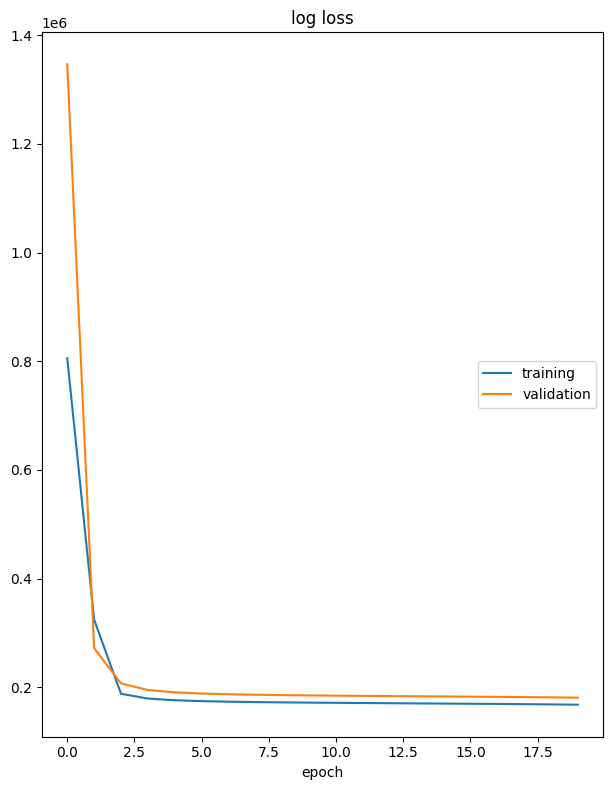

log loss
	training         	 (min: 168108.312, max: 805646.438, cur: 168108.312)
	validation       	 (min: 181056.688, max: 1346298.125, cur: 181056.688)


In [ ]:
# Plot the learning curve of the model
plot_learning_curve(n_epochs, train_loader, val_loader, optimizer, criterion, model, device)

### Understanding the Log Loss Plot

The log loss plot provides a visual representation of the logarithmic loss values for both the training and validation datasets during the model training process. Once starting the training process, the first epoch resulted in the maximum training log loss of 246,658.672. After that, the loss dropped rapidly and then decreased slowly over eopches, reaching a minimum of 28,619.750 eventually. This curve illustrates the model's performance on the training set, showcasing fluctuations in the loss function throughout the training iterations. Simultaneously, the validation log loss evolved in a very similar way, starting with 261,797.203 to 30,468.529.  Simultaneously, the validation log loss, varying between a minimum of 30,468.529 and a maximum of 261,797.203, is currently at 30,468.529. The validation curve reflects the model's generalization to unseen data, with the plot capturing the trends in loss values during the validation phase.

After comparing with other alternative models, this model has the lowest error and largest similarity. Therefore, we choose it as our final model.

## Plotting the next 3 predicted images

In [ ]:
def predict_next_3_images(model, X, y, std, mean):
    """
    Predict three images next to given consecutive images using a given model

    Parameters
    ----------
    model: torch.nn.Module

        The model to be used for prediction.

    X: torch.Tensor

        The tensor of input consecutive images with shape (batch_size, sequence_length, channels, height, width).

    y: torch.Tensor

        The true image next to the input consecutive images.
        If predicting without label, set y=None.

    std: float

        The standard deviation of the pixel values of all the images of a storm.

    mean: float

        The mean of the pixel values of all the images of a storm.

    """
    model.eval()
    X = X.to(device)
    y_pred = model(X)
    y_pred_array = (y_pred[0, :, 0, :, :]*std + mean).detach().cpu().numpy()

    # Plot true images and corresponding predicted images
    # and also compute the (structural) similarity and MSE between each pair of
    # true and predicted images
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    for i in range(3):
        axs[i].imshow(y_pred_array[i])
        axs[i].set(title=f"Predicted image {i+1}")
    plt.show()
    if y is not None:
        y_array = (y[0, :, 0, :, :]*std + mean).detach().cpu().numpy()
        similarities, errors = [], []
        fig, axs = plt.subplots(1, 3, figsize=(14, 4))
        for i in range(3):
            axs[i].imshow(y_array[i])
            axs[i].set(title=f"True image {i+1}")
            similarity = ssim(y_pred_array[i], y_array[i])
            similarities.append(similarity)
            error = mse(y_pred_array[i], y_array[i])
            errors.append(error)
        plt.show()
        return similarities, errors
    return

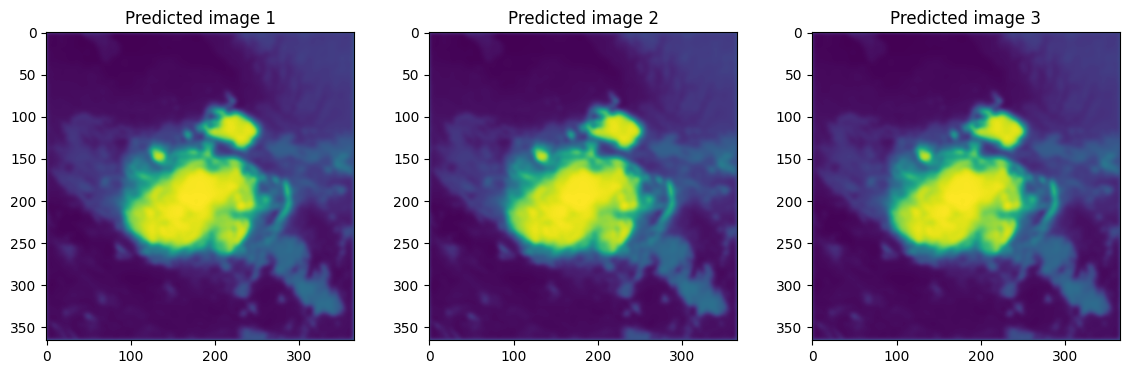

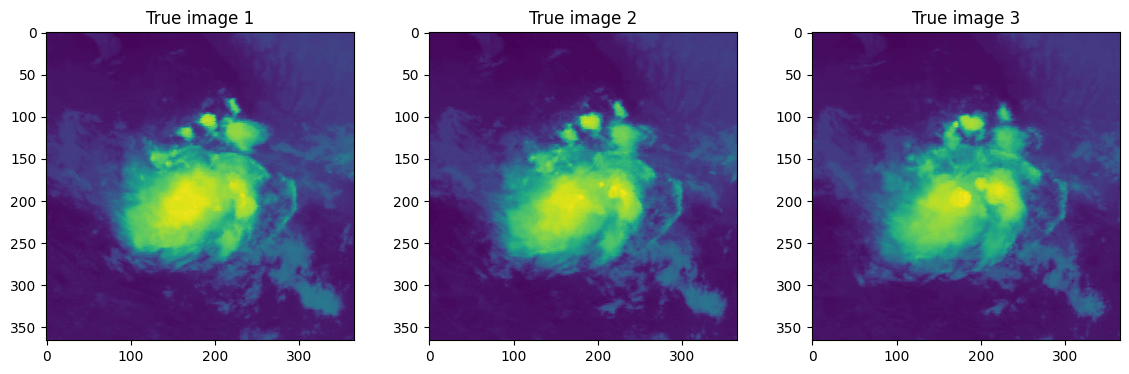

Image 1 
 Structural similarity = 0.8589504996850579 
 MSE = 0.00500804176312407
Image 2 
 Structural similarity = 0.8307653293293573 
 MSE = 0.0070082794127996825
Image 3 
 Structural similarity = 0.7868274494965039 
 MSE = 0.008887237599601193


In [ ]:
# Predict the next 3 images
X, y = next(iter(val_loader))
similarities, errors = predict_next_3_images(model, X, y, std, mean)
for i in range(3):
    print(f"Image {i+1}", '\n', 'Structural similarity =', similarities[i], '\n', 'MSE =', errors[i])

## Techniques used to Enhance Image Sharpness

1. Pixel Density Augmentation: One approach involved augmenting the number of pixels in the images. It produced slightly improved output images. The `StormDataset` class in `Model.py` supports resizing images. Adding the number of pixels can sharpen images but consumes more computational time and resources.

2. Greyscale Conversion: Another method explored was the conversion of images from RGB to greyscale, with the expectation that it would enhance the visibility of picture edges. However, the results indicated that using RGB maintained more distinctive features compared to the greyscale counterpart. The `StormDataset` class in `Model.py` transforms images into the greyscale one automatically.

3. Custom Sharpening Methods: In an effort to boost image sharpness, a custom sharpening method was employed by adjusting the alpha value. Despite these attempts, the outcomes were not as promising, suggesting the need for alternative strategies for achieving sharper images.

## Hyperparameter tuning

We used "bkh" storm data to perform hyperparameter tuning.

In [ ]:
# Create all possible combination of hyperparameters
hyperparams_dict = {
    "lr": [5e-4, 1e-3],
    "num_convlstm_en": [2, 3],
    "num_convlstm_de": [2, 3, 4],
    "batch_size": [2]
}
hyperparams_combinations = generate_combinations(hyperparams_dict)

{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convlstm_de': 2, 'batch_size': 2}


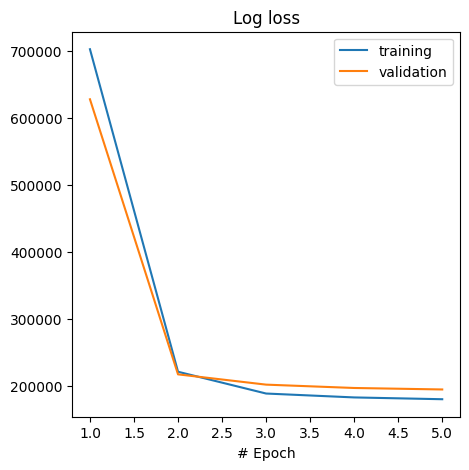

Image 1 
 Structural similarity = 0.8562946520085214 
 MSE = 0.005202078982080808 

Image 2 
 Structural similarity = 0.8165540087023206 
 MSE = 0.007315966937340223 

Image 3 
 Structural similarity = 0.7895298767729265 
 MSE = 0.009136544038752884 

{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convlstm_de': 3, 'batch_size': 2}


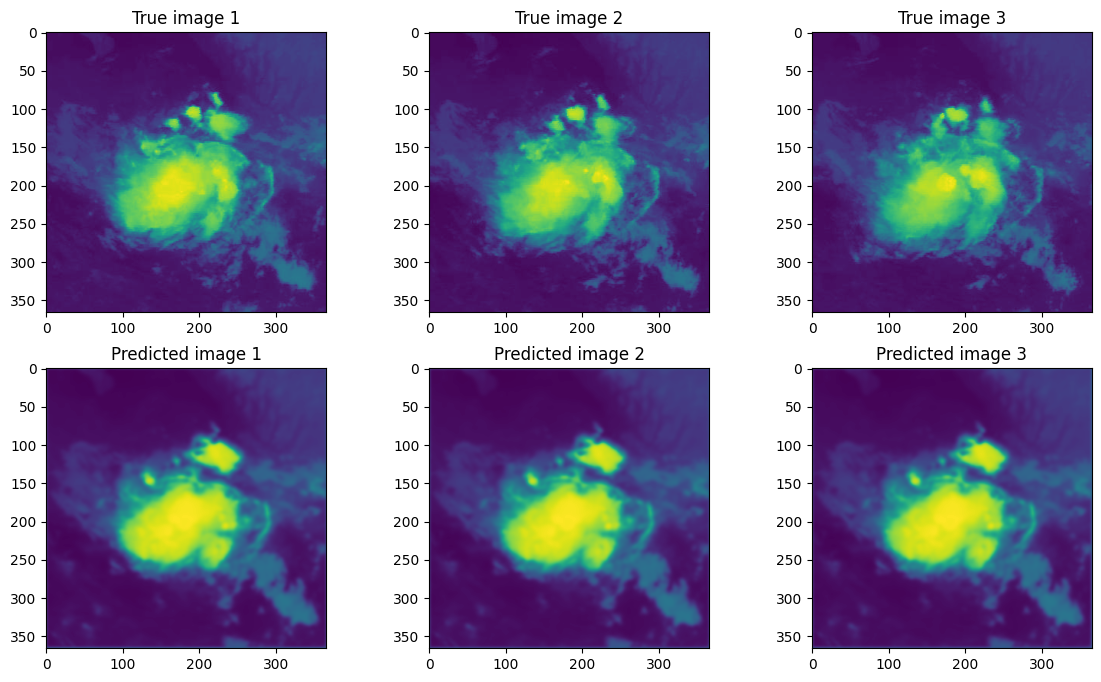

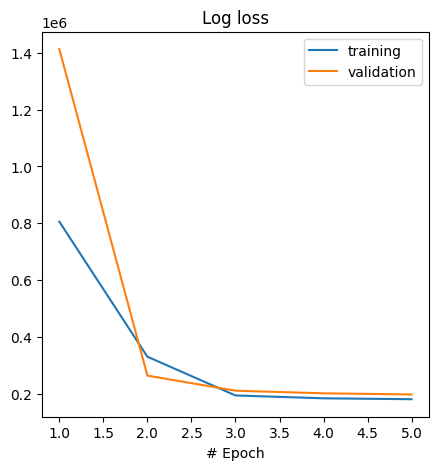

Image 1 
 Structural similarity = 0.8600204631823178 
 MSE = 0.005098356213114614 

Image 2 
 Structural similarity = 0.8249494049756299 
 MSE = 0.007487730904830233 

Image 3 
 Structural similarity = 0.7660674014179162 
 MSE = 0.009397761248892399 

{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convlstm_de': 4, 'batch_size': 2}


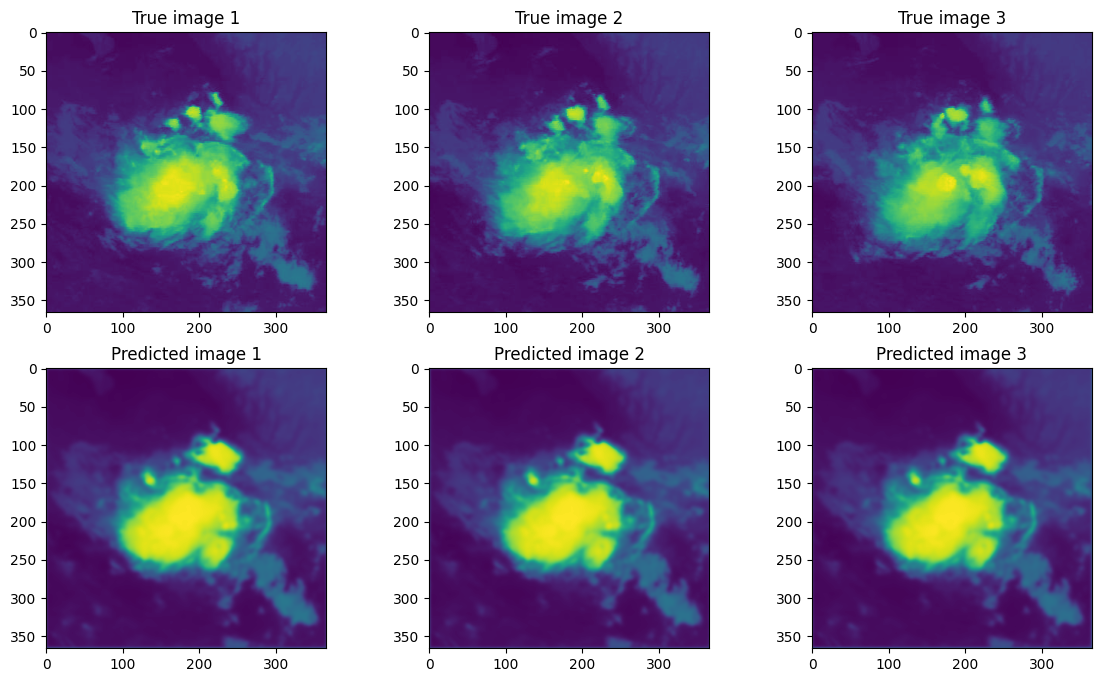

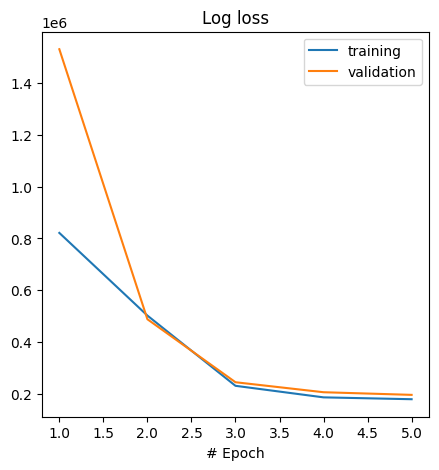

Image 1 
 Structural similarity = 0.858103108367683 
 MSE = 0.005171355381089818 

Image 2 
 Structural similarity = 0.8204192885818606 
 MSE = 0.007374008272301508 

Image 3 
 Structural similarity = 0.7556082276799622 
 MSE = 0.009358300351488732 

{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convlstm_de': 2, 'batch_size': 2}


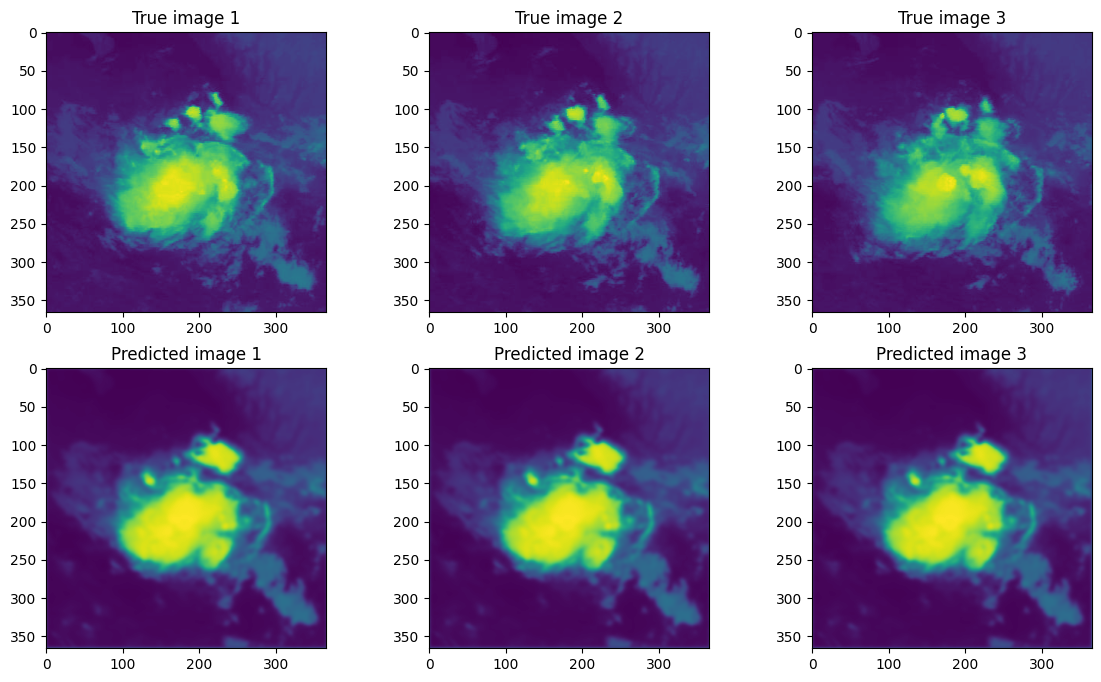

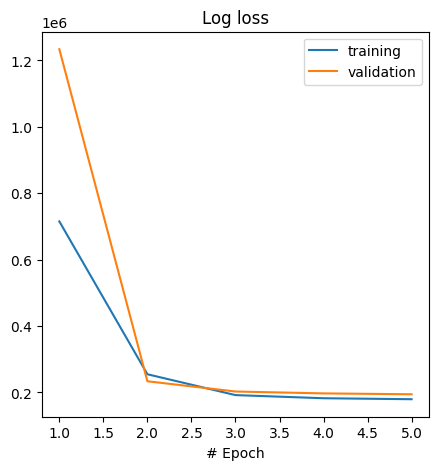

Image 1 
 Structural similarity = 0.8559705082711383 
 MSE = 0.0051635730210087775 

Image 2 
 Structural similarity = 0.8269105724453752 
 MSE = 0.007383994240579628 

Image 3 
 Structural similarity = 0.7800930273679272 
 MSE = 0.009129881269875779 

{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convlstm_de': 3, 'batch_size': 2}


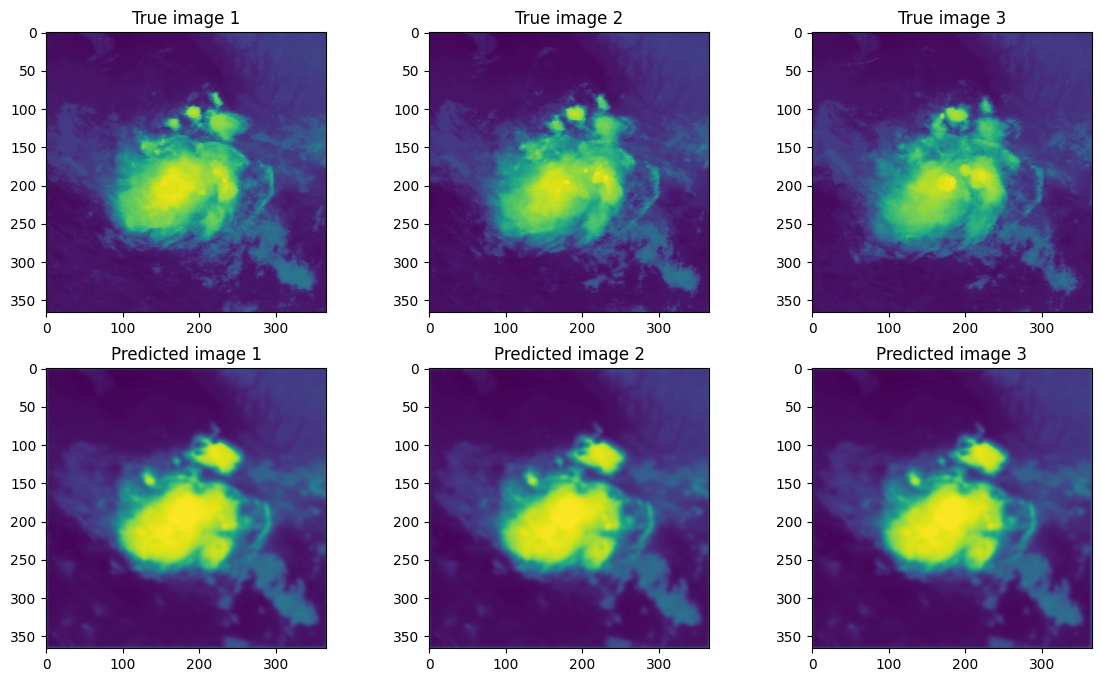

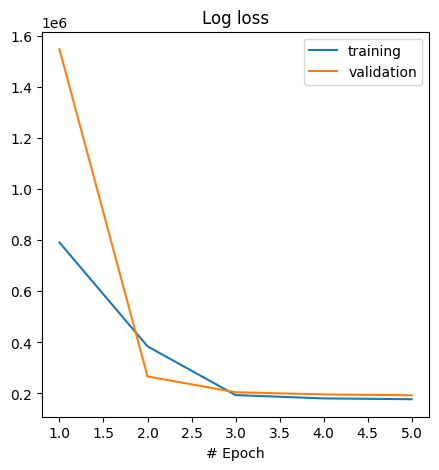

Image 1 
 Structural similarity = 0.8567455753544435 
 MSE = 0.005239373598596094 

Image 2 
 Structural similarity = 0.8249985341058199 
 MSE = 0.0074826173529082265 

Image 3 
 Structural similarity = 0.7810012374244654 
 MSE = 0.009163740144964122 

{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convlstm_de': 4, 'batch_size': 2}


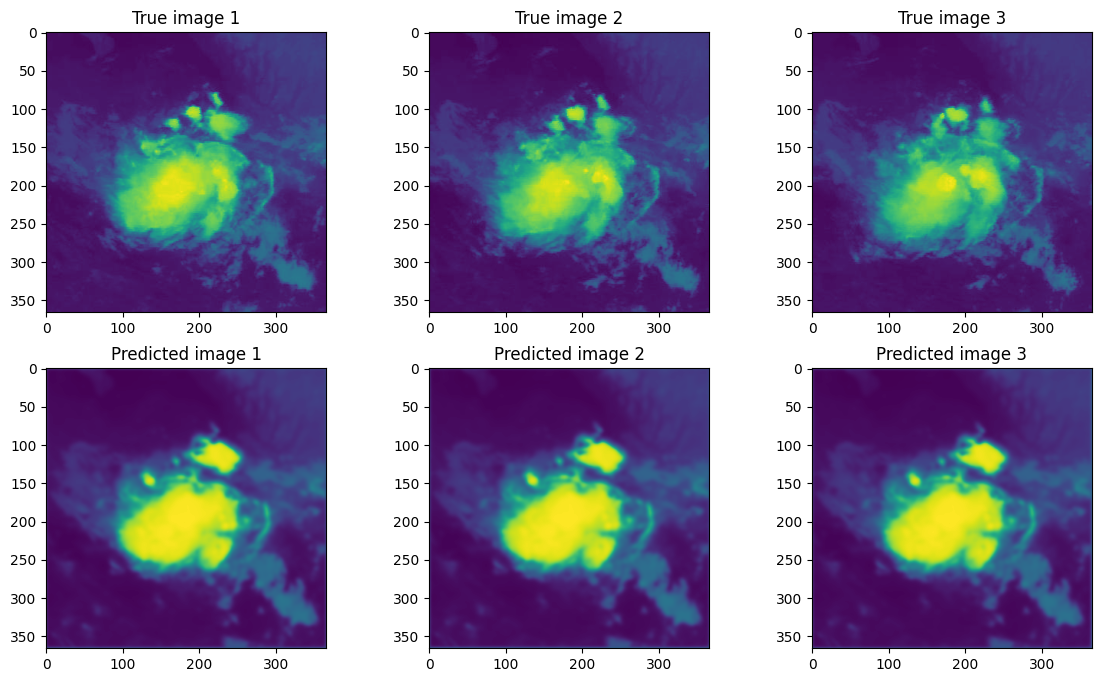

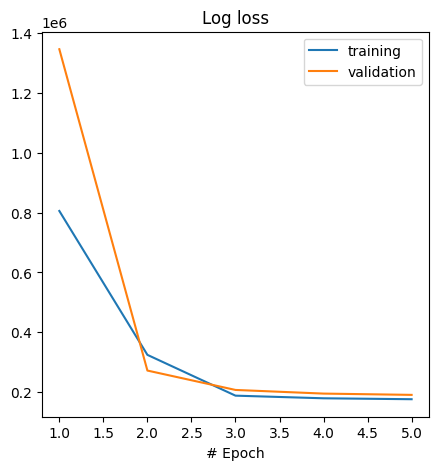

Image 1 
 Structural similarity = 0.859986122970635 
 MSE = 0.005072914563042412 

Image 2 
 Structural similarity = 0.8272258787782747 
 MSE = 0.0071345103085270695 

Image 3 
 Structural similarity = 0.7724093762130823 
 MSE = 0.009149717295068643 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 2, 'batch_size': 2}


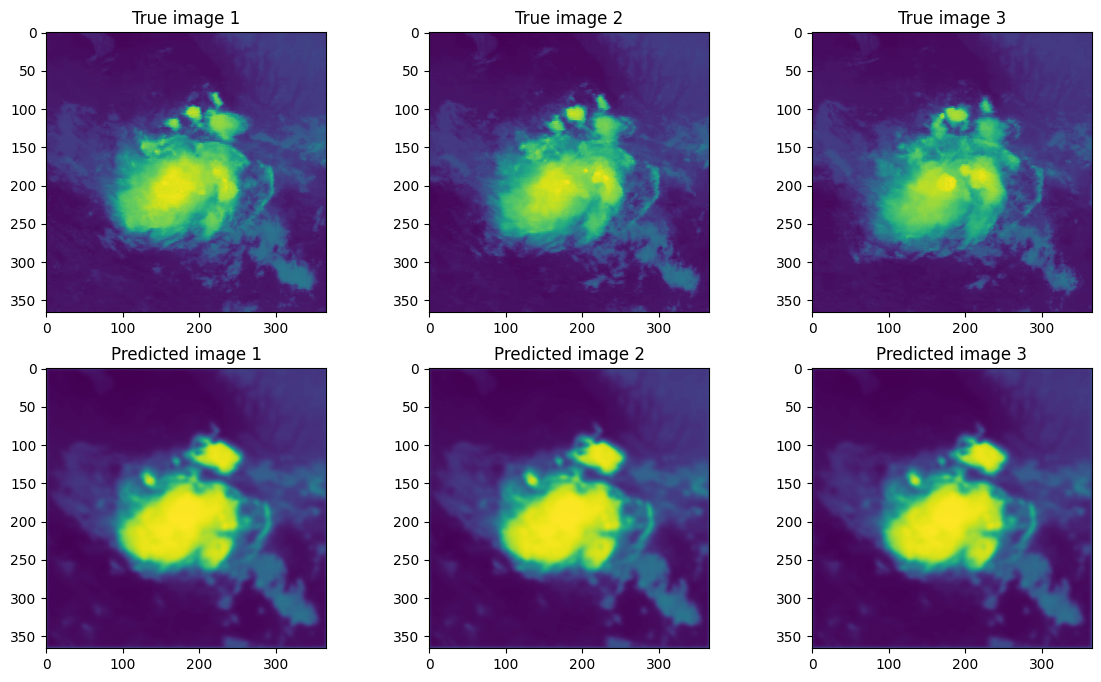

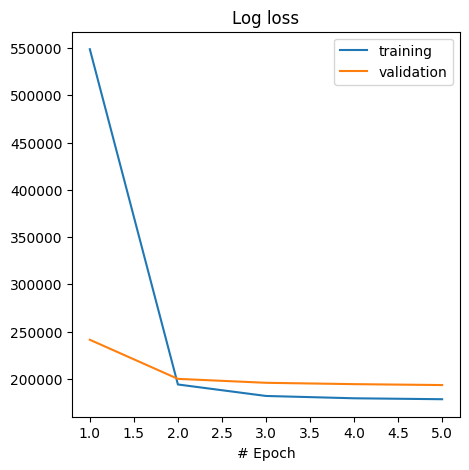

Image 1 
 Structural similarity = 0.8543567846997614 
 MSE = 0.005277939767781632 

Image 2 
 Structural similarity = 0.8228612876062368 
 MSE = 0.00738663465651285 

Image 3 
 Structural similarity = 0.7837773365979438 
 MSE = 0.009166136659751974 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 3, 'batch_size': 2}


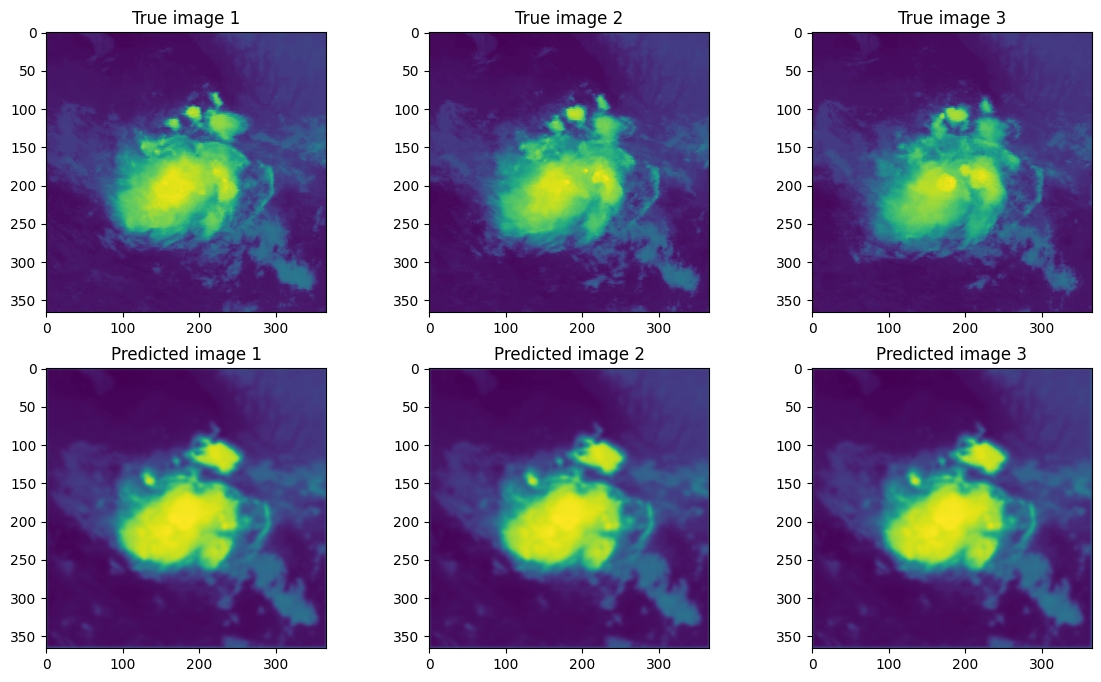

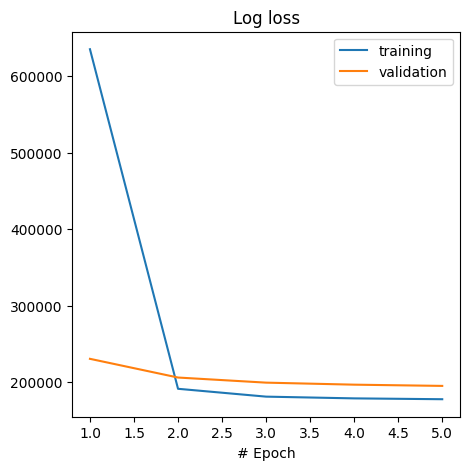

Image 1 
 Structural similarity = 0.857564382047976 
 MSE = 0.005112277022515897 

Image 2 
 Structural similarity = 0.8158599129024517 
 MSE = 0.007442927629139508 

Image 3 
 Structural similarity = 0.7710898266188961 
 MSE = 0.009348874900885975 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 4, 'batch_size': 2}


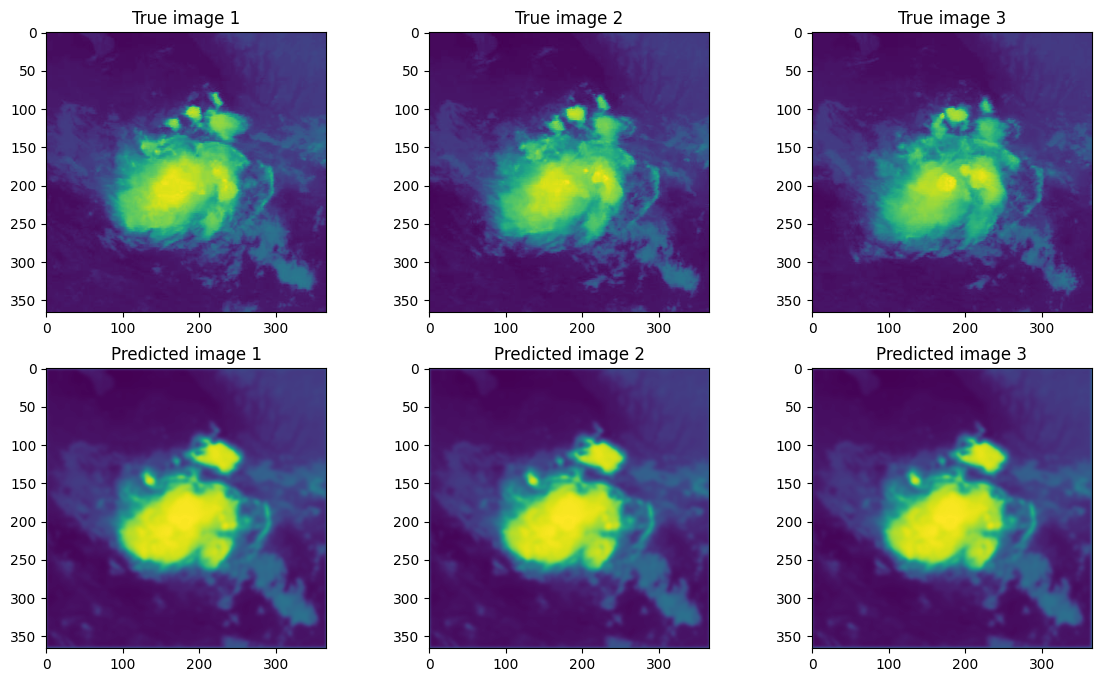

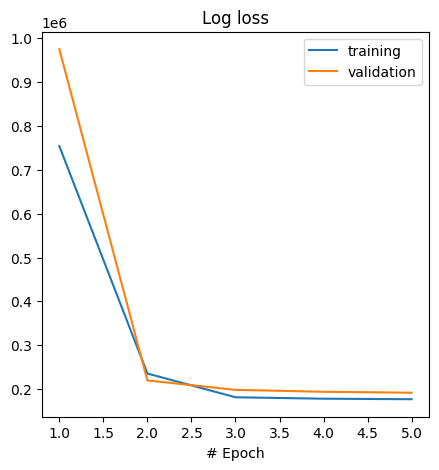

Image 1 
 Structural similarity = 0.8574522862566426 
 MSE = 0.005215408640082449 

Image 2 
 Structural similarity = 0.8221783102643226 
 MSE = 0.007380361194044287 

Image 3 
 Structural similarity = 0.7785639980892212 
 MSE = 0.009268228212042411 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 2, 'batch_size': 2}


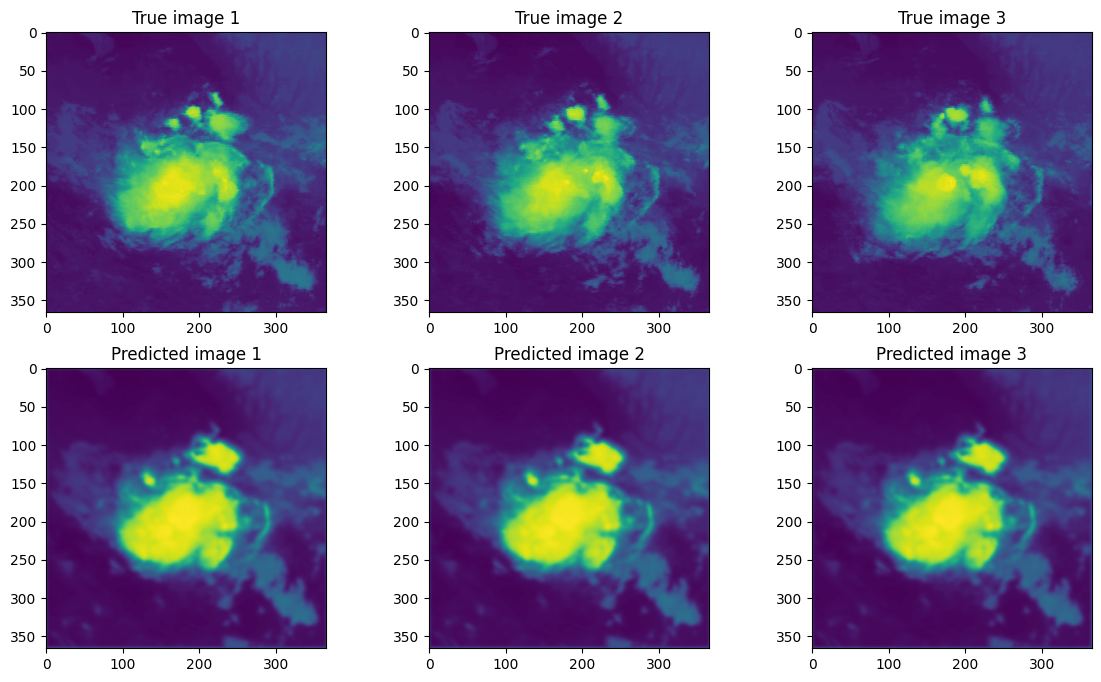

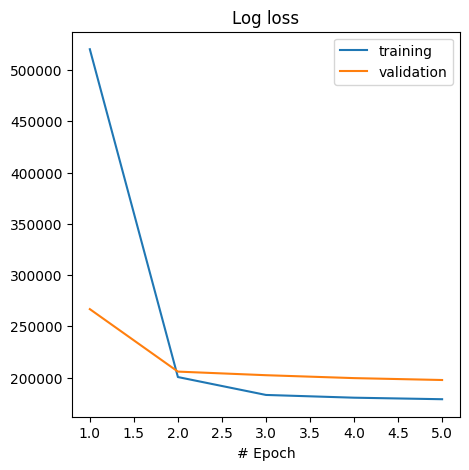

Image 1 
 Structural similarity = 0.855421336667344 
 MSE = 0.005334641339093998 

Image 2 
 Structural similarity = 0.811177679762051 
 MSE = 0.007664294960830454 

Image 3 
 Structural similarity = 0.7682553964823783 
 MSE = 0.009496271722634576 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 3, 'batch_size': 2}


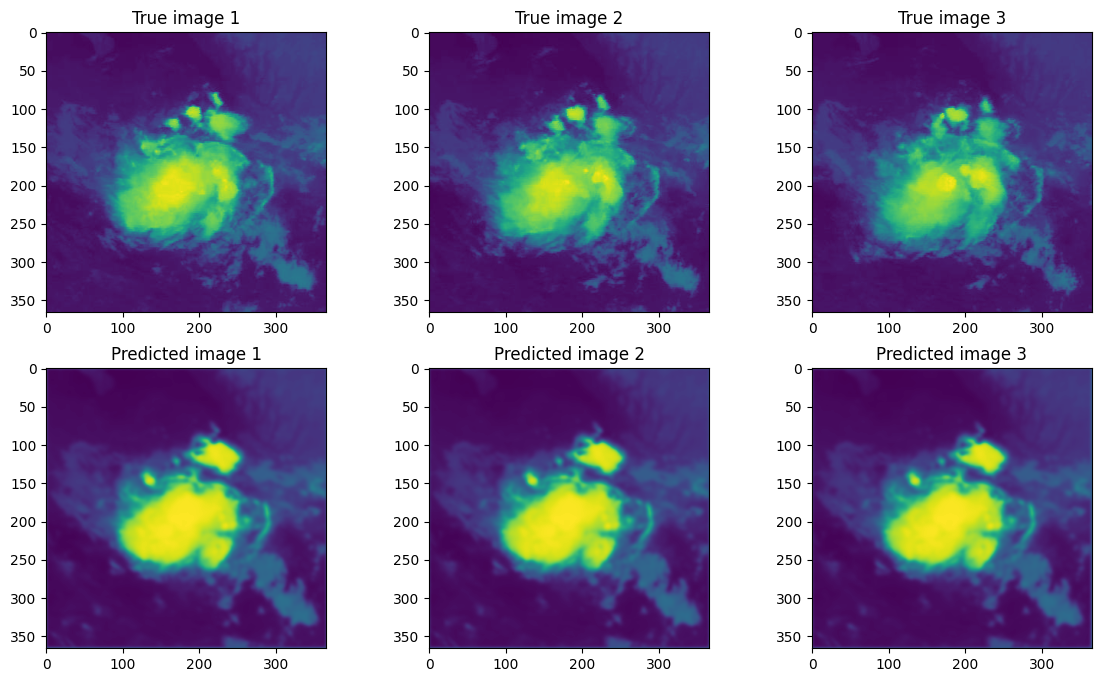

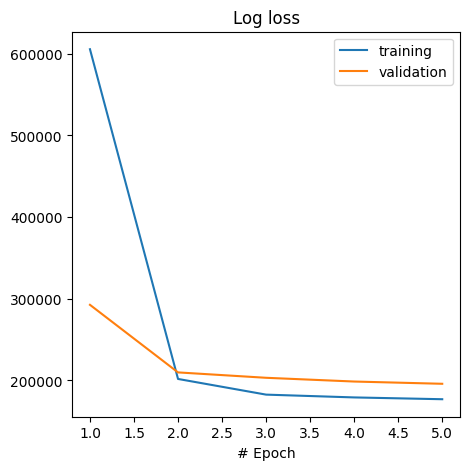

Image 1 
 Structural similarity = 0.8573983614111206 
 MSE = 0.005189177539351683 

Image 2 
 Structural similarity = 0.8147645123432767 
 MSE = 0.007509577515066499 

Image 3 
 Structural similarity = 0.7704770546437213 
 MSE = 0.009415317878564282 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 4, 'batch_size': 2}


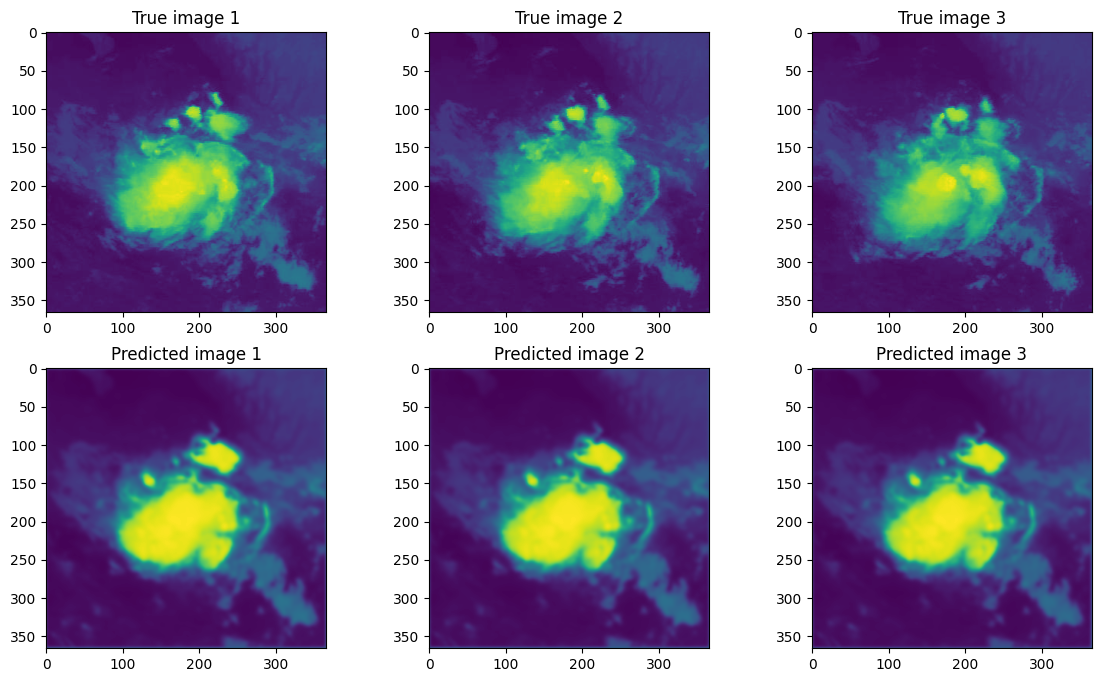

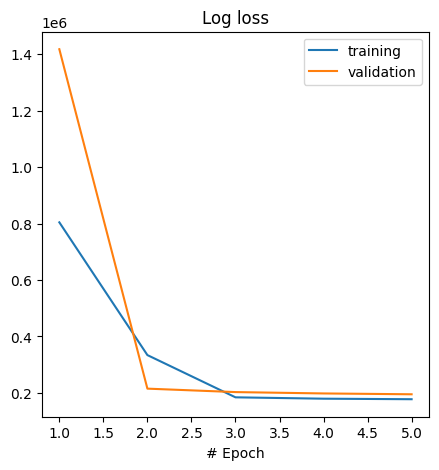

Image 1 
 Structural similarity = 0.8540647321755004 
 MSE = 0.005152103948489897 

Image 2 
 Structural similarity = 0.8119251695978136 
 MSE = 0.007303723389181051 

Image 3 
 Structural similarity = 0.7631218602143282 
 MSE = 0.00942355338527037 



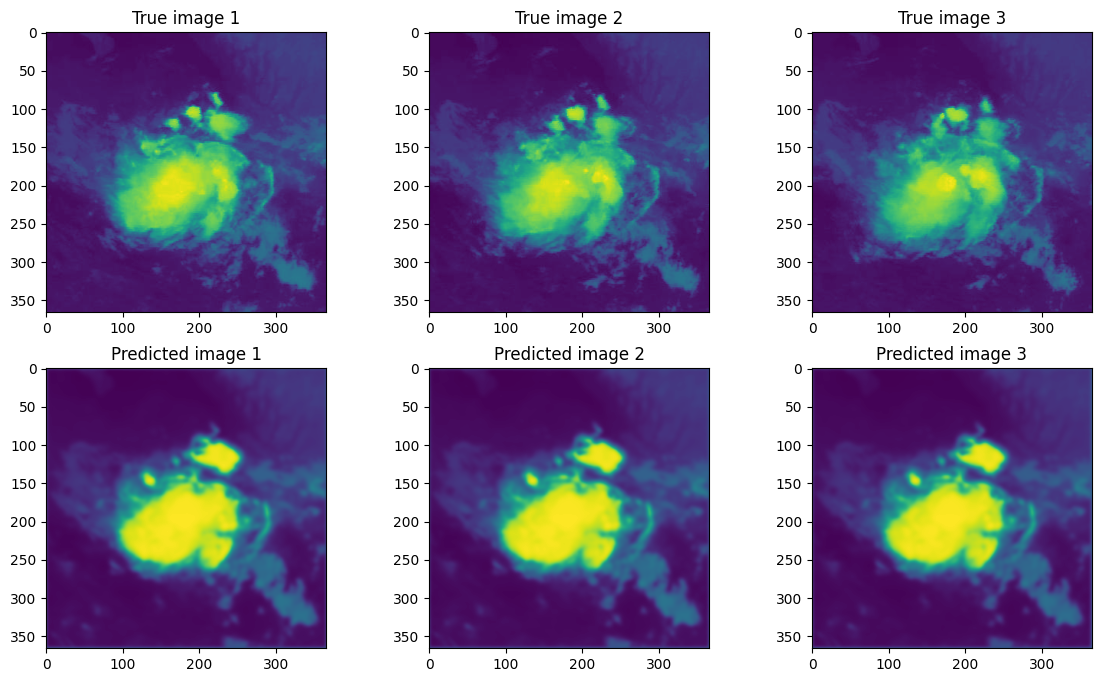

In [ ]:
# Loop over all the combinations
similarities_1_2_3_list, errors_1_2_3_list = [], []
for hyperparams in hyperparams_combinations:
    # Set hyperparameters
    print(hyperparams)
    set_seed(0)
    lr = hyperparams['lr']
    num_convlstm_en = hyperparams['num_convlstm_en']
    num_convlstm_de = hyperparams['num_convlstm_de']
    batch_size = hyperparams['batch_size']
    n_epochs = 5
    # Create the data loaders of the training and validation datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    # Initialise a model, a criterion, and an optimiser
    set_seed(0)
    model = EncoderDecoderConvLSTM(
        input_chan=1, num_convlstm_en=num_convlstm_en, num_convlstm_de=num_convlstm_de
    ).to(device)
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    # Loop to train
    for _ in range(n_epochs):
        train_losses.append(train(train_loader, optimizer, criterion, model, device))
        val_losses.append(validate(val_loader, criterion, model, device))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(range(1, n_epochs+1), train_losses, label='training')
    ax.plot(range(1, n_epochs+1), val_losses, label='validation')
    ax.set(title='Log loss', xlabel='# Epoch')
    ax.legend()
    plt.show()

    # Predict 3 images next to the 20 consecutive images packed in the features (X) in the first batch of the validation loader
    X, y = next(iter(val_loader))
    similarities, errors = predict_next_3_images(model, X, y, std, mean)
    plt.show()
    similarities_1_2_3_list.append(similarities)
    errors_1_2_3_list.append(errors)
    for i in range(3):
        print(f"Image {i+1}", '\n', 'Structural similarity =', similarities[i], '\n', 'MSE =', errors[i], '\n')

In [ ]:
# Show the (sorted) results as a DataFrame
similarities_1_2_3_array = np.array(similarities_1_2_3_list).T
errors_1_2_3_array = np.array(errors_1_2_3_list).T
tuning_result_df = pd.DataFrame({
    "Similarity 1": similarities_1_2_3_array[0],
    "Similarity 2": similarities_1_2_3_array[1],
    "Similarity 3": similarities_1_2_3_array[2],
    "Similarity Sum": np.sum(similarities_1_2_3_array, axis=0),
    "MSE 1": errors_1_2_3_array[0],
    "MSE 2": errors_1_2_3_array[1],
    "MSE 3": errors_1_2_3_array[2],
    "MSE Sum": np.sum(errors_1_2_3_array, axis=0),
}, index=hyperparams_combinations)
tuning_result_df.sort_values(by="MSE Sum")

Similarity 1  \
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.859986   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.856295   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.855971   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.854357   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.857452   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.854065   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.856746   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.858103   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.857564   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.860020   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.857398   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.855421   

                                                    Similarity 2  \
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.827226   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.816554   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.826911   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.822861   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.822178   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.811925   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.824999   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.820419   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.815860   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.824949   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.814765   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.811178   

                                                    Similarity 3  \
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.772409   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.789530   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.780093   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.783777   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.778564   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.763122   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...      0.781001   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.755608   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...      0.771090   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...      0.766067   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.770477   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...      0.768255   

                                                    Similarity Sum     MSE 1  \
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...        2.459621  0.005073   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...        2.462379  0.005202   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...        2.462974  0.005164   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...        2.460995  0.005278   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...        2.458195  0.005215   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...        2.429112  0.005152   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...        2.462745  0.005239   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...        2.434131  0.005171   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...        2.444514  0.005112   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...        2.451037  0.005098   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...        2.442640  0.005189   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...        2.434854  0.005335   

                                                       MSE 2     MSE 3  \
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...  0.007135  0.009150   
{'lr': 0.0005, 'num_convlstm_en': 2, 'num_convl...  0.007316  0.009137   
{'lr': 0.0005, 'num_convlstm_en': 3, 'num_convl...  0.007384  0.009130   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...  0.007387

Note
- Some hyperparameters, e.g., `beta1`, `beta2` and `epsilon` of an `Adam` optimiser, are not needed to be tuned (https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar/)
- `kernel_size=3` works best
  - `kernel_size=1` produces images with lower similarities (higher MSEs) and various quailty (some are less blurred, but some are very bad)
  - `kernel_size=5` produces images with higher similarities (lower MSEs) but more blurred
- Adding batch normalisation and/or dropout produces worser images
- `batch_size=1` leads to the generation of images with higher similarities (lower MSEs) than `batch_size=2`, but the results look very similar, and the resulted learning curve looks better as the log losses of the training and validation are very similar when `batch_size=2`.

## Producing the model for each storm

In [ ]:
def save_model_and_optimizer(storing_dir, model, model_filename, optimizer, optimizer_filename):
    """Save the model and the optimizer."""
    model_path = f"{storing_dir}/{model_filename}"
    torch.save(model.state_dict(), model_path)
    optimizer_path = f"{storing_dir}/{optimizer_filename}"
    torch.save(optimizer.state_dict(), optimizer_path)

In [ ]:
# Loop over each storm to create, train, and export the model for it
for storm_id, storm_ds in all_storm_ds.items():
    # Train-test split
    train_set = storm_ds[:int(len(storm_ds)*0.8)]
    val_set = storm_ds[int(len(storm_ds)*0.8):]

    # Create the data loaders of the training and validation datasets
    batch_size = 2
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Initialise an encoder-decoder convolutional LSTM model
    set_seed(0)
    model = EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=3, num_convlstm_de=4).to(device)

    # Set hyperparameters, criterion, and optimiser
    lr = 5e-4
    n_epochs = 20
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Loop to train
    for _ in range(n_epochs):
        train(train_loader, optimizer, criterion, model, device)

    # Save the model and the optimiser
    storing_dir = "/content/drive/MyDrive/Storm_Project/30_models_new"
    model_filename = f"model_{storm_id}.pt"
    optimizer_filename = f"optimizer_{storm_id}.pt"
    save_model_and_optimizer(storing_dir, model, model_filename, optimizer, optimizer_filename)

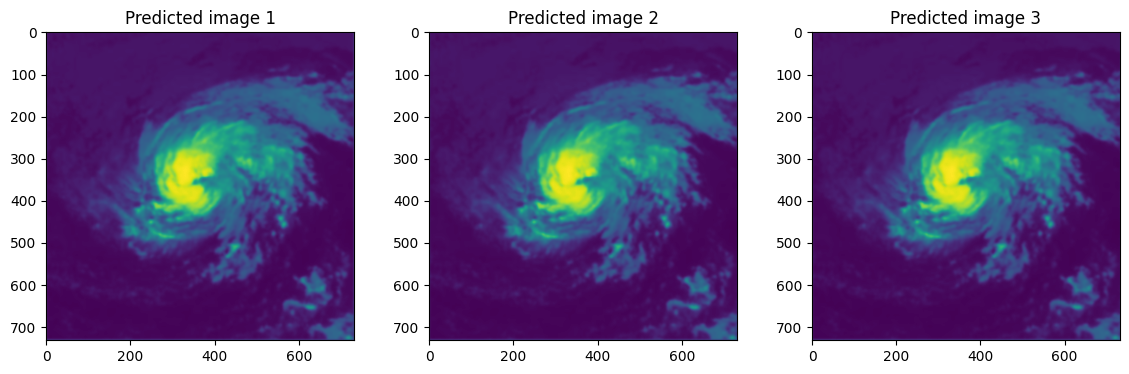

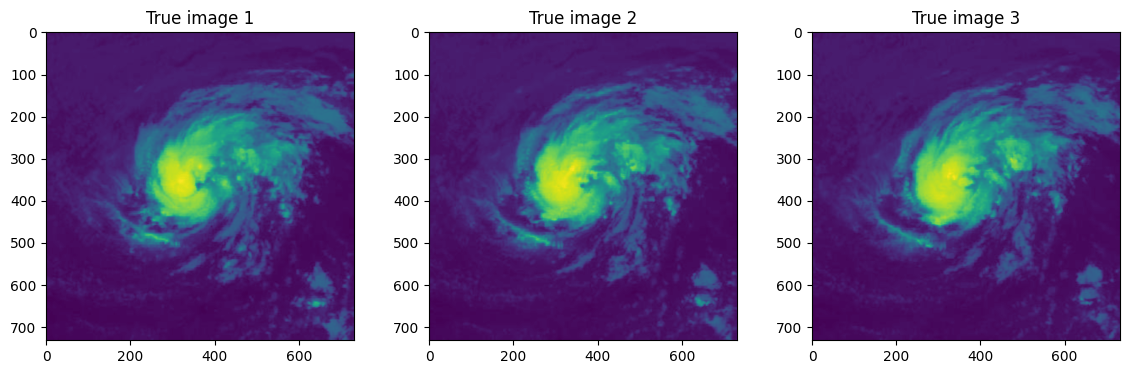

Image 1 
 Structural similarity = 0.8791725772657609 
 MSE = 0.004007705209876907
Image 2 
 Structural similarity = 0.8735231535081505 
 MSE = 0.005085535517317721
Image 3 
 Structural similarity = 0.8657964241483727 
 MSE = 0.006136195638539469


In [ ]:
# Initialise a StormDataset object for the storm "blq"
storm_id = "blq"
storm_ds = StormDataset(
    all_data,
    storm_id,
    num_sequence=20,
    all_images_dict=images,
    img_size=366*2
)

# Train-test split
train_set = storm_ds[:int(len(storm_ds)*0.8)]
val_set = storm_ds[int(len(storm_ds)*0.8):]

# Create the data loaders of the training and validation datasets
batch_size = 2
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Create an instance of the model
set_seed(0)
model = EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=3, num_convlstm_de=4).to(device)

# Load the parameters of the model in path
storing_dir = "/content/drive/MyDrive/Storm_Project/30_models_new"
model_filename = f"model_{storm_id}.pt"
model.load_state_dict(torch.load(f"{storing_dir}/{model_filename}"))

# Predict 3 images next to the 20 consecutive images packed in the features (X) in the first batch of the validation loader
X, y = next(iter(val_loader))
similarities, errors = predict_next_3_images(model, X, y, storm_ds.std, storm_ds.mean)
for i in range(3):
    print(f"Image {i+1}", '\n', 'Structural similarity =', similarities[i], '\n', 'MSE =', errors[i])

## Predicting 3 images next to unseen image series

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Storm_Project/data_tst.csv")
data

storm_id  relative_time  ocean  wind_speed image_file_name
0        tst              0      1        31.0     tst_000.jpg
1        tst           1800      1        32.0     tst_001.jpg
2        tst           3601      1        33.0     tst_002.jpg
3        tst           5400      1        33.0     tst_003.jpg
4        tst           7200      1        34.0     tst_004.jpg
..       ...            ...    ...         ...             ...
247      tst         532799      1         NaN     tst_247.jpg
248      tst         534599      1         NaN     tst_248.jpg
249      tst         536398      1         NaN     tst_249.jpg
250      tst         539999      1         NaN     tst_250.jpg
251      tst         541799      1         NaN     tst_251.jpg

[252 rows x 5 columns]

In [ ]:
# Get all storm images
zip_path = '/content/drive/MyDrive/Storm_Project/surprise_storm_image.zip'
unseen_images = get_images_from_zip(zip_path)

252


In [ ]:
# Get the last 21 images to be used for prediction
last_21_unseen_img_name_list = sorted(unseen_images.keys())[-21:]
last_21_unseen_img = [unseen_images[name] for name in last_21_unseen_img_name_list]

In [ ]:
# Create a feature (X) with a shape of (2, 20, 1, h, w) to be used for prediction suing the last 21 images
x1 = torch.stack([ToTensor()(img) for img in last_21_unseen_img[:20]])
x2 = torch.stack([ToTensor()(img) for img in last_21_unseen_img[1:]])
X = torch.stack([x1, x2])
print(X.shape)

torch.Size([2, 20, 1, 366, 366])


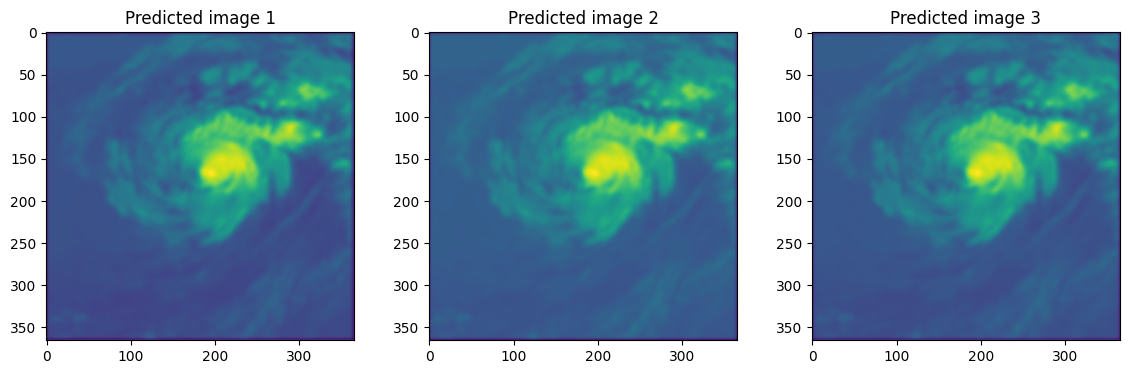

In [ ]:
# Create an instance of the model
set_seed(0)
model = EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=3, num_convlstm_de=4).to(device)

# Load the parameters of the model in path (use the model trained using "bkh" storm)
model.load_state_dict(torch.load("/content/drive/MyDrive/Storm_Project/30_models_new/model_bkh.pt"))

# Initialise a StormDataset object for the unseen storm ("tst")
storm = "tst"
storm_ds = StormDataset(data, storm, num_sequence=20, all_images_dict=unseen_images, img_size=366)

# Predict 3 images next to the 20 consecutive images packed in the features (X) in the first batch of the validation loader
predict_next_3_images(model, X, None, storm_ds.std, storm_ds.mean)

## Model Ensemble

We trained 29 models for different single storms with the best hyperparameters. However, when we use the model to predict another storm, it does not work well. The MSE of it reaches 0.062, and the predictions look strange and vague.

In [ ]:
ensemble_weights0 = np.zeros(29)
ensemble_weights0[0] = 1
validate(ensemble_weights0,model, val_loader , criterion,device)

0.06179352787633737

Structural similarity = 0.6346344816362751
MSE = tensor(0.0494, device='cuda:0')


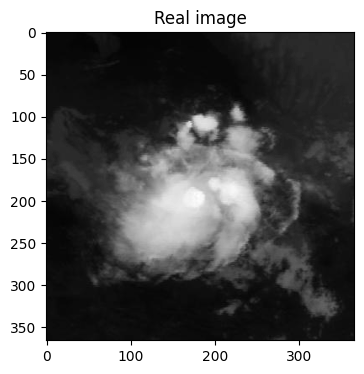

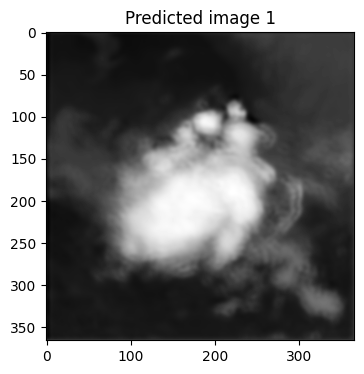

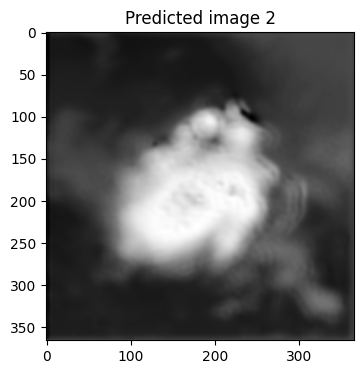

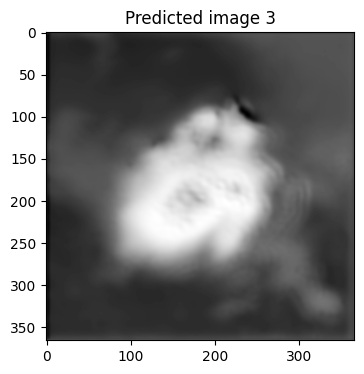

In [ ]:
for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    y_true = (y[0, 0, 0, :, :]).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(y_true, cmap='gray')
    ax.set(title="Real image")
    for i in range(3):
        weighted_outputs, loss = validate(model, X,y,ensemble_weights0,criterion,device)

        y_true = (y[0, 0, 0, :, :]).detach().cpu().numpy()
        y_pred = (weighted_outputs.view(-1, 366, 366)[0, :]).detach().cpu().numpy()
        # Plot
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(y_pred,cmap='gray')
        ax.set(title=f"Predicted image {i+1}")

        # Remove the first element in the second dimension of X
        X = X[:, 1:, :, :, :]
        # Concatenate y as the last element in the second dimension
        X = torch.cat((X, weighted_outputs), dim=1)

      # Compute structural similarity and MSE between the first predicted image and the label
        if i == 0:
            similarity = ssim(y_pred, y_true)
            error = loss
            # print(weighted_output, y_true)
            print("Structural similarity =", similarity)
            print("MSE =", error)


    break

The low-quality production may be due to what we predict is based on the properties from another storm. It triggers use to ensemble all the 29 models we have trained. The ensembled model is the weighted average of the outputs from all the pretrained models.

In [ ]:
models = [EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=3, num_convlstm_de=4).to(device) for _ in range(29)]
storing_dir = "/content/drive/MyDrive/Storm_Project/30_models"
i = 0
for storm_id in all_storm_ids:
  print(storm_id)
  if storm_id != "bkh":
      model_filename = "model_" + storm_id + ".pt"
      models[i].load_state_dict(torch.load(f"{storing_dir}/{model_filename}", map_location=torch.device('cpu')))
      i += 1

In [ ]:
models

[EncoderDecoderConvLSTM(
   (convlstm_encoders): ModuleList(
     (0): ConvLSTMCell(
       (conv): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (1): ConvLSTMCell(
       (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (2): ConvLSTMCell(
       (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
   )
   (convlstm_decoders): ModuleList(
     (0): ConvLSTMCell(
       (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (1): ConvLSTMCell(
       (conv): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (2): ConvLSTMCell(
       (conv): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
     (3): ConvLSTMCell(
       (conv): Conv2d(5, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
   )
   (cnn_decoders): Sequential(
     (0): Conv3d(3, 3, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))

In [ ]:
def weighted_model(models, X, y, ensemble_weights,criterion,device):
  weighted_outputs = torch.zeros_like(y)
  with torch.no_grad():
    for i in range(len(models)):
      y_pred = models[i](X)
      weighted_outputs += ensemble_weights[i] * y_pred / sum(ensemble_weights)
    loss = criterion(weighted_outputs, y)
  return weighted_outputs, loss

We optimize the ensemble weight to minimize the MSE of our prediction for a new storm. The 30th storm is considered as a new storm and used for the optimization.

In [ ]:
num_models = 29
ensemble_weights = np.ones(num_models)/num_models

In [ ]:
def ensemble_loss(ensemble_weights, models, dataloader,criterion,device):
  total_loss = 0
  with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      weighted_outputs = torch.zeros_like(y)

      for i, model in enumerate(models):
        model.eval()
        y_pred = model(X)
        weighted_outputs += ensemble_weights[i] * y_pred
      weighted_outputs = weighted_outputs/sum(ensemble_weights)
      loss = criterion(weighted_outputs, y)
      total_loss+= loss.item()
  return total_loss/len(dataloader)

In [ ]:
from scipy.optimize import minimize

# Bounds for the weights (each weight should be between 0 and 1)
bounds = [(0, 1)] * (num_models)

criterion = torch.nn.MSELoss()

# Optimize weights
result = minimize(ensemble_loss, ensemble_weights, args=( models, train_loader,criterion,device),
                  method='Nelder-Mead', bounds=bounds, options={'maxiter': 100})

optimal_weights = result.x

print("Optimal weights:", optimal_weights)

Optimal weights: [0.03152904 0.03609099 0.03646759 0.03506229 0.03589197 0.03339256
 0.03392021 0.03221106 0.03364124 0.03682032 0.03483119 0.03054161
 0.03146184 0.03363156 0.03876775 0.03625424 0.03252011 0.03302359
 0.03474157 0.03704674 0.03619817 0.03527209 0.03761744 0.03499679
 0.0347378  0.03181998 0.03270318 0.03398123 0.03605958]


The ensemble model could predict a new storm with a lower MSE and greatly improve the quality of the figures.

In [ ]:
ensemble_loss(optimal_weights,models, train_loader , criterion,device)

0.014252178884374026

Structural similarity = 0.6617139413434276
MSE = tensor(0.0410, device='cuda:0')


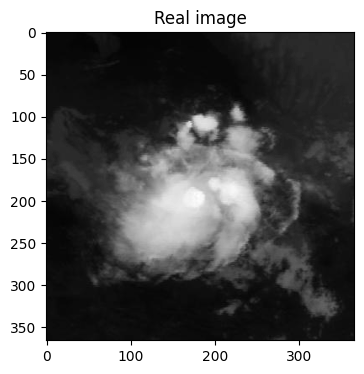

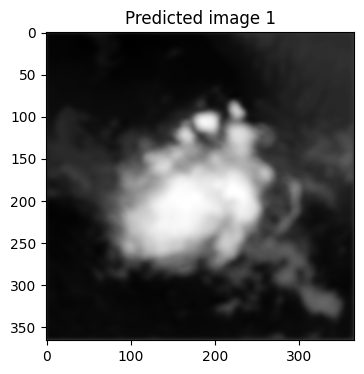

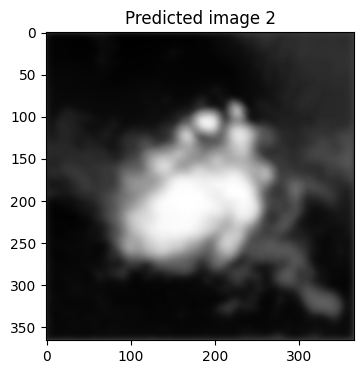

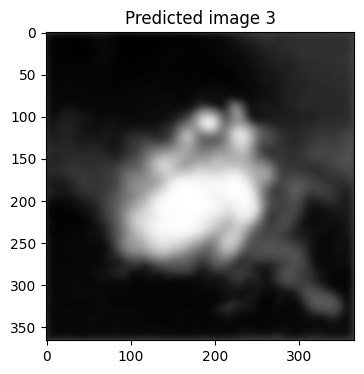

In [ ]:
for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    y_true = (y[0, 0, 0, :, :]).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(y_true, cmap='gray')
    ax.set(title="Real image")
    for i in range(3):
        weighted_outputs, loss = weighted_model(models, X,y,optimal_weights,criterion,device)

        y_true = (y[0, 0, 0, :, :]).detach().cpu().numpy()
        y_pred = (weighted_outputs.view(-1, 366, 366)[0, :]).detach().cpu().numpy()
        # Plot
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(y_pred,cmap='gray')
        ax.set(title=f"Predicted image {i+1}")

        # Remove the first element in the second dimension of X
        X = X[:, 1:, :, :, :]
        # Concatenate y as the last element in the second dimension
        X = torch.cat((X, weighted_outputs), dim=1)

      # Compute structural similarity and MSE between the first predicted image and the label
        if i == 0:
            similarity = ssim(y_pred, y_true)
            error = loss
            # print(weighted_output, y_true)
            print("Structural similarity =", similarity)
            print("MSE =", error)


    break

However, the prediction images are still vague and blurry. This may be because we average the outputs so that fuzz the sharp parts. Compared to the single model trained with the new storm, it has a much higher error and lower similarity, since each storm has its characteristics. The ensemble model, combining the traits of 29 storms, would just show an average of them, rather than predicting the behaviour of a new storm. Though all the storms have something in common, the quality of predictions relies more on presenting the features of the specific storm. The three predictions become more and more vague since we are using the previous predictions, which expands the errors.

In conclusion, with a large enough dataset of the new storm, the model trained specifically for this storm would outperform the ensembled model from other training datasets. Since we have enough training data for the surprise storm, we use the model trained with the surprise storm only for prediction.
